**Note: if running on vagrant VM, make sure you have installed fonts-noto and fonts-emojione:

`sudo apt install fonts-noto fonts-emojione`

Also make sure packages are installed as usual, with:

`sudo pip install -r requirements.txt`

# Feature Extraction

In previous weeks we have collected data, and then preprocessed it, including tokenisation to split the text into meaningful units ("words"). Given usable text and a token list, next we will look to extract features by counting occurrences of different elements and calculating other features over the text, tokens, and other features.

* [Preamble](#preamble)
* [Bag of Words](#bow)
    - [Filtered List](#filtered)
    - [Word N-grams](#wordn)
* [Characters](#chars)
    - [Char N-grams](#charn)
* [Annotation](#ann)
* [Other features](#other)
* [Documents](#docs)
* [Corpus analysis](#corpus)
* [TF-IDF](#tfidf)
* [Exercise](#ex)

<a id="preamble"></a>
## Preamble
We can use code from last week to preprocess our text, a method is defined below to do some basic preprocessing, please check your understanding. You may see fit to edit the preprocessing to suit your needs later.

In [1]:
import ftfy
import re

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

To demonstrate the feature extraction, we're going to start by working with a single tweet:

In [2]:
tweet = "This week we’re at a #careers event in #Blackpool @Pleasure_Beach, talking to students about #languages and language careers! Come have a go at some of our activities! 🌏#LoveLanguages #LoveLancaster @Lancaster_CI https://t.co/vQQWdrUuqh"

In [3]:
p_tweet = preprocess(tweet)
print(p_tweet)

This week we're at a [hashtag] event in [hashtag] [mention], talking to students about [hashtag] and language careers! Come have a go at some of our activities! 🌏[hashtag] [hashtag] [mention] [url]


For tokenisation, we have a basic custom tokeniser. This is equivalent to the custom tokenisers created last week, but with a pre-compiled regular expression. Alternation is used to separate patterns. Again, you may see fit to edit to suit your needs later.

In [4]:
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def custom_tokenise(text):
    return tokenise_re.findall(text)

Utility methods for displaying/saving tokens list. Can be used for any list.

In [5]:
def print_tokens(tokens):
    for token in tokens: #iterate tokens and print one per line.
        print(token)
    print(f"Total: {len(tokens)} tokens")

In [6]:
def save_tokens(tokens, outfile):
    with open(outfile, 'w', encoding="utf-8") as f:
        for token in tokens: #iterate tokens and output to file.
            f.write(token + '\n')
        f.write(f"Total: {len(tokens)} tokens")

<a id="bow"></a>
## Bag of words

Probably the most common NLP feature set, traditionally, is the "bag of words". This is a count of each word in the text, disregarding context. Whilst limited, due to the lack of context, a simple bag of words can achieve reasonable results for simple classification tasks, and is often used as a baseline.

First we need to tokenise the text. The tokenisation used will determine what is considered a "word", although post processing of the token list could be undertaken, e.g. to filter.

In [7]:
tokens = custom_tokenise(p_tweet)

In [8]:
print_tokens(tokens)

This
week
we're
at
a
[hashtag]
event
in
[hashtag]
[mention]
,
talking
to
students
about
[hashtag]
and
language
careers
!
Come
have
a
go
at
some
of
our
activities
!
🌏
[hashtag]
[hashtag]
[mention]
[url]
Total: 35 tokens


For simple bag of words, it often makes sense to make the token list all lowercase, so the same word with different casings are merged (e.g. if a word is at the beginning of a sentence).

In [9]:
lower_tokens = [t.lower() for t in tokens] #list comprehension
print_tokens(lower_tokens)

this
week
we're
at
a
[hashtag]
event
in
[hashtag]
[mention]
,
talking
to
students
about
[hashtag]
and
language
careers
!
come
have
a
go
at
some
of
our
activities
!
🌏
[hashtag]
[hashtag]
[mention]
[url]
Total: 35 tokens


Note that Python's `lower()` method is Unicode aware, and will lowercase letters with diacritics and from non-Latin alphabets.

In [10]:
"ÅÉÎÑÇΛФ".lower()

'åéîñçλф'

To make a frequency list, we simply place the token list in a [`Counter`](https://docs.python.org/3.7/library/collections.html#counter-objects) object, which extends `dict`, mapping items to frequencies. [NLTK's FreqDist](http://www.nltk.org/_modules/nltk/probability.html#FreqDist), which extends `Counter`, could also be used.

In [11]:
from collections import Counter

tokens_fql = Counter(lower_tokens)

In [12]:
tokens_fql.most_common() #displays frequency list in descending frequency order.

[('[hashtag]', 5),
 ('at', 2),
 ('a', 2),
 ('[mention]', 2),
 ('!', 2),
 ('this', 1),
 ('week', 1),
 ("we're", 1),
 ('event', 1),
 ('in', 1),
 (',', 1),
 ('talking', 1),
 ('to', 1),
 ('students', 1),
 ('about', 1),
 ('and', 1),
 ('language', 1),
 ('careers', 1),
 ('come', 1),
 ('have', 1),
 ('go', 1),
 ('some', 1),
 ('of', 1),
 ('our', 1),
 ('activities', 1),
 ('🌏', 1),
 ('[url]', 1)]

<a id="filtered"></a>
### Filtered list

At some point we will need to filter the bag of words, e.g. to some top-500 or top-1000 words, as it rarely makes sense to have a feature vector containing all words.

The method below uses word frequencies to create a new frequency list containing all in the predefined lists. Including 0s for words not found (dense vector). The vector can be made sparse (remove 0s) by with `+counter`.

In [13]:
def filter_fql(fql, predefined_list):
    return Counter({t: fql[t] for t in predefined_list}) #dict comprehension, t: fql[t] is token: freq.

A common feature set (especially for authorship analysis) is function words (aka stop words). Here we use the function word list taken from https://ieeexplore.ieee.org/abstract/document/6234420.

In [14]:
def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

In [15]:
fws = read_list("functionwords.txt")

In [16]:
fws_fql = filter_fql(tokens_fql, fws)
fws_fql.most_common()

[('a', 2),
 ('at', 2),
 ('about', 1),
 ('and', 1),
 ('have', 1),
 ('in', 1),
 ('of', 1),
 ('our', 1),
 ('some', 1),
 ('this', 1),
 ('to', 1),
 ('able', 0),
 ('aboard', 0),
 ('above', 0),
 ('absent', 0),
 ('according', 0),
 ('accordingly', 0),
 ('across', 0),
 ('after', 0),
 ('against', 0),
 ('ahead', 0),
 ('albeit', 0),
 ('all', 0),
 ('along', 0),
 ('alongside', 0),
 ('although', 0),
 ('am', 0),
 ('amid', 0),
 ('amidst', 0),
 ('among', 0),
 ('amongst', 0),
 ('amount', 0),
 ('an', 0),
 ('another', 0),
 ('anti', 0),
 ('any', 0),
 ('anybody', 0),
 ('anyone', 0),
 ('anything', 0),
 ('are', 0),
 ('around', 0),
 ('as', 0),
 ('aside', 0),
 ('astraddle', 0),
 ('astride', 0),
 ('away', 0),
 ('bar', 0),
 ('barring', 0),
 ('be', 0),
 ('because', 0),
 ('been', 0),
 ('before', 0),
 ('behind', 0),
 ('being', 0),
 ('below', 0),
 ('beneath', 0),
 ('beside', 0),
 ('besides', 0),
 ('better', 0),
 ('between', 0),
 ('beyond', 0),
 ('bit', 0),
 ('both', 0),
 ('but', 0),
 ('by', 0),
 ('can', 0),
 ('certain'

Remove 0s, and make into sparse vector: 

In [17]:
+fws_fql

Counter({'a': 2,
         'about': 1,
         'and': 1,
         'at': 2,
         'have': 1,
         'in': 1,
         'of': 1,
         'our': 1,
         'some': 1,
         'this': 1,
         'to': 1})

Note you need to be careful that the tokenisation matches what is in the function word / stopword list.

You could also use NLTK's stopword list.

In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stoplist = stopwords.words('english')
print(stoplist)

[nltk_data] Downloading package stopwords to /home/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

We can remove words from a list (e.g. a stopword list) by iterating the list of words to remove, and 'popping off' ([dict.pop(key,None)](https://docs.python.org/3/library/stdtypes.html?highlight=pop#dict.pop)) each word if present. 

In [19]:
def remove_list(fql, to_remove):
    filtered = Counter(fql)
    for r in to_remove:
        filtered.pop(r,None)        
    return filtered

filtered = remove_list(tokens_fql, stoplist)
print(filtered)

Counter({'[hashtag]': 5, '[mention]': 2, '!': 2, 'week': 1, "we're": 1, 'event': 1, ',': 1, 'talking': 1, 'students': 1, 'language': 1, 'careers': 1, 'come': 1, 'go': 1, 'activities': 1, '🌏': 1, '[url]': 1})


<a id="wordn"></a>
### Word n-grams

To get some context for words, we can use sequences of words instead of single words, these are known as word n-grams. bigrams (2-grams) and trigrams (3-grams) are popular. One issue with word n-grams is their sparsity. It's a good idea to reduce the size of the vocabulary as much as possible, e.g. digits and dates could be mapped to single tokens.

Whether a token appears at the start or end of the text (or could be sentence) can be useful, so we can introduce buffer markers at the start and end to indicate this.

Note also that n-grams should be created with a sliding window over the text, i.e. the first word bigram is the first and second word, the second bigram is the second and third word.

The method below is a generic method for turning a list of tokens into an n-gram list, adding the buffer characters either side, and moving a sliding window of size n across the text and providing a list of n-grams.

In [20]:
def ngrams(tokens, n, sep = "_", buffer="^"):
    buffered = [buffer] * (n-1) + tokens + [buffer] * (n-1) #add buffer either side to denote start and end
    return [sep.join(buffered[i:i+n]) for i in range(len(buffered)-n+1)] #list comprehension creating merged string of n chars, with a window of n through string

In [21]:
word_bigrams = ngrams(lower_tokens,2)

In [22]:
word_bigrams

['^_this',
 'this_week',
 "week_we're",
 "we're_at",
 'at_a',
 'a_[hashtag]',
 '[hashtag]_event',
 'event_in',
 'in_[hashtag]',
 '[hashtag]_[mention]',
 '[mention]_,',
 ',_talking',
 'talking_to',
 'to_students',
 'students_about',
 'about_[hashtag]',
 '[hashtag]_and',
 'and_language',
 'language_careers',
 'careers_!',
 '!_come',
 'come_have',
 'have_a',
 'a_go',
 'go_at',
 'at_some',
 'some_of',
 'of_our',
 'our_activities',
 'activities_!',
 '!_🌏',
 '🌏_[hashtag]',
 '[hashtag]_[hashtag]',
 '[hashtag]_[mention]',
 '[mention]_[url]',
 '[url]_^']

In [23]:
word_bigrams_fql = Counter(word_bigrams)
word_bigrams_fql.most_common()

[('[hashtag]_[mention]', 2),
 ('^_this', 1),
 ('this_week', 1),
 ("week_we're", 1),
 ("we're_at", 1),
 ('at_a', 1),
 ('a_[hashtag]', 1),
 ('[hashtag]_event', 1),
 ('event_in', 1),
 ('in_[hashtag]', 1),
 ('[mention]_,', 1),
 (',_talking', 1),
 ('talking_to', 1),
 ('to_students', 1),
 ('students_about', 1),
 ('about_[hashtag]', 1),
 ('[hashtag]_and', 1),
 ('and_language', 1),
 ('language_careers', 1),
 ('careers_!', 1),
 ('!_come', 1),
 ('come_have', 1),
 ('have_a', 1),
 ('a_go', 1),
 ('go_at', 1),
 ('at_some', 1),
 ('some_of', 1),
 ('of_our', 1),
 ('our_activities', 1),
 ('activities_!', 1),
 ('!_🌏', 1),
 ('🌏_[hashtag]', 1),
 ('[hashtag]_[hashtag]', 1),
 ('[mention]_[url]', 1),
 ('[url]_^', 1)]

**Task:** Produce a frequency list of word trigrams.

<a id="chars"></a>
## Characters

Just looking at characters as features is a simple (yet often powerful) way of processing text.

In [24]:
print(tweet)

This week we’re at a #careers event in #Blackpool @Pleasure_Beach, talking to students about #languages and language careers! Come have a go at some of our activities! 🌏#LoveLanguages #LoveLancaster @Lancaster_CI https://t.co/vQQWdrUuqh


In [25]:
print(p_tweet)

This week we're at a [hashtag] event in [hashtag] [mention], talking to students about [hashtag] and language careers! Come have a go at some of our activities! 🌏[hashtag] [hashtag] [mention] [url]


We probably don't want the artificial hashtag, mention, and url markers, we could keep these as is, replace with single chars, or just remove them. Below we just remove them. We often have different pre-processing for different features.

In [26]:
def preprocess_remove(text):
    r_text = hashtag_re.sub("",text)
    r_text = mention_re.sub("",r_text)
    r_text = url_re.sub("",r_text)
    r_text = ftfy.fix_text(r_text)
    return r_text

In [27]:
r_tweet = preprocess_remove(tweet)
print(r_tweet)

This week we're at a  event in  , talking to students about  and language careers! Come have a go at some of our activities! 🌏   


Note, extra spaces are included now, how could you preprocess the text further to reduce multiple spaces to a single space?

In Python a string is just a sequence (list) of characters, so we can just iterate through the characters as below:

In [28]:
for char in r_tweet:
    print(char)

T
h
i
s
 
w
e
e
k
 
w
e
'
r
e
 
a
t
 
a
 
 
e
v
e
n
t
 
i
n
 
 
,
 
t
a
l
k
i
n
g
 
t
o
 
s
t
u
d
e
n
t
s
 
a
b
o
u
t
 
 
a
n
d
 
l
a
n
g
u
a
g
e
 
c
a
r
e
e
r
s
!
 
C
o
m
e
 
h
a
v
e
 
a
 
g
o
 
a
t
 
s
o
m
e
 
o
f
 
o
u
r
 
a
c
t
i
v
i
t
i
e
s
!
 
🌏
 
 
 


We can make thus count the frequency of each character easily:

In [29]:
char_fql = Counter(r_tweet)
char_fql.most_common()

[(' ', 30),
 ('e', 14),
 ('a', 12),
 ('t', 10),
 ('o', 7),
 ('i', 6),
 ('s', 6),
 ('n', 6),
 ('r', 4),
 ('g', 4),
 ('u', 4),
 ('v', 3),
 ('h', 2),
 ('w', 2),
 ('k', 2),
 ('l', 2),
 ('d', 2),
 ('c', 2),
 ('!', 2),
 ('m', 2),
 ('T', 1),
 ("'", 1),
 (',', 1),
 ('b', 1),
 ('C', 1),
 ('f', 1),
 ('🌏', 1)]

This appears to work well, **but this should be used with caution**:

In [30]:
test = "Remember the spicy jalapen\u0303o"
print(test)

Remember the spicy jalapeño


In [31]:
for i, char in enumerate(test):
    print(i,char)

0 R
1 e
2 m
3 e
4 m
5 b
6 e
7 r
8  
9 t
10 h
11 e
12  
13 s
14 p
15 i
16 c
17 y
18  
19 j
20 a
21 l
22 a
23 p
24 e
25 n
26 ̃
27 o


Notice the  ̃ separated from the n because it is a separate codepoint (combining).

This gets worse if we view the characters as a list:

In [32]:
print(list(test))

['R', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 't', 'h', 'e', ' ', 's', 'p', 'i', 'c', 'y', ' ', 'j', 'a', 'l', 'a', 'p', 'e', 'n', '̃', 'o']


See the  ̃ over the single quote mark. Nasty! 🤢

The combining codepoint combines with whatever the character before is, and in this case it's displayed as the quote mark.

We need to be careful how we define "character". In Python a 'character' is a single Unicode codepoint. When in reality, we should be looking for "graphemes", i.e. displayed single characters (which may be a cluster of codepoints): https://unicode.org/reports/tr29/#Grapheme_Cluster_Boundaries

We can use regular expressions to find these graphemes, but Python's default regular expression library (re), whilst being Unicode aware, does not deal with Unicode particularly well. The [regex library](https://pypi.org/project/regex/) has better support, providing the use of unicode categories: https://www.regular-expressions.info/unicode.html, including `\X` to match single graphemes.

In [33]:
import regex
#!{sys.executable} -m pip install regex
char_regex = regex.compile(r'\X')

In [34]:
chars = char_regex.findall(test)
print(chars)

['R', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 't', 'h', 'e', ' ', 's', 'p', 'i', 'c', 'y', ' ', 'j', 'a', 'l', 'a', 'p', 'e', 'ñ', 'o']


This nicely separates ñ as single "character". We can put this into a frequency list:

In [35]:
char_fql = Counter(chars)
char_fql.most_common()

[('e', 5),
 (' ', 3),
 ('m', 2),
 ('p', 2),
 ('a', 2),
 ('R', 1),
 ('b', 1),
 ('r', 1),
 ('t', 1),
 ('h', 1),
 ('s', 1),
 ('i', 1),
 ('c', 1),
 ('y', 1),
 ('j', 1),
 ('l', 1),
 ('ñ', 1),
 ('o', 1)]

Even more "fun" can be had with emojis, which can contain numerous codepoints, particularly joined with zero-width-joiners: https://unicode.org/emoji/charts/emoji-zwj-sequences.html.

In [36]:
emoji_test = "This is an emoji: \U0001F468\u200D\U0001F469\u200D\U0001F467\u200D\U0001F466"

In [37]:
print(emoji_test)

This is an emoji: 👨‍👩‍👧‍👦


In [38]:
test_matches = char_regex.findall(emoji_test)

In [39]:
for match in test_matches:
    print(match)

T
h
i
s
 
i
s
 
a
n
 
e
m
o
j
i
:
 
👨‍👩‍👧‍👦


(You must have the latest version (2019.2.18) of the regex library for this to work, there was a bug I actually found whilst preparing this lab, which has now been fixed: https://bitbucket.org/mrabarnett/mrab-regex/issues/312/x-not-matching-graphemes-with-zero-width.)

Another library, [grapheme](https://pypi.org/project/grapheme/), also provides funtionality to deal with these graphemes like characters.

In [40]:
import grapheme

In [41]:
graphemes = list(grapheme.graphemes(emoji_test))

In [42]:
for g in graphemes:
    print(g)

T
h
i
s
 
i
s
 
a
n
 
e
m
o
j
i
:
 
👨‍👩‍👧‍👦


In [43]:
char_fql = Counter(graphemes)
char_fql.most_common()

[(' ', 4),
 ('i', 3),
 ('s', 2),
 ('T', 1),
 ('h', 1),
 ('a', 1),
 ('n', 1),
 ('e', 1),
 ('m', 1),
 ('o', 1),
 ('j', 1),
 (':', 1),
 ('👨\u200d👩\u200d👧\u200d👦', 1)]

Note, when composite graphemes are printed in a list/tuple, they're expanded for some reason (if you know why, please tell me!). As can be seen, this is just a display issue:

In [44]:
for char in char_fql.most_common():
    print("{}\t{}".format(char[0], char[1]))

 	4
i	3
s	2
T	1
h	1
a	1
n	1
e	1
m	1
o	1
j	1
:	1
👨‍👩‍👧‍👦	1


<a id="charn"></a>
### Character n-grams

We can also look at sequences of characters, though be aware that these will overlap with words and other features (double counting).

You have everything you need to do this (remember the n-grams function is generic).

**Task:** Produce character trigrams for the tweet. You don't need a separator for chars, so the first trigram should be '^^T'

<a id="ann"></a>
## Annotation

As discussed in the lecture, various levels of annotation are available to add on top of the tokens. These are extra levels of information that can be used as features for various NLP tasks. Lemmatisation is one option available and straightforward to [implement with nltk](http://www.nltk.org/book/ch03.html#lemmatization).

Part-of-speech (POS) tags are probably the most used form of annotation, certainly for classification tasks. NLTK provides a POS tagger using the standard [Penn Treebank POS tagset](https://www.anc.org/penn.html). Tokenised text can be POS tagged easily:

In [45]:
nltk.download('punkt')
nltk.download('maxent_treebank_pos_tagger')
pos_tagged = nltk.pos_tag(tokens)
pos_tagged

[nltk_data] Downloading package punkt to /home/jay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/jay/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('week', 'NN'),
 ("we're", 'NN'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('[hashtag]', 'JJ'),
 ('event', 'NN'),
 ('in', 'IN'),
 ('[hashtag]', 'NNP'),
 ('[mention]', 'NNP'),
 (',', ','),
 ('talking', 'VBG'),
 ('to', 'TO'),
 ('students', 'NNS'),
 ('about', 'IN'),
 ('[hashtag]', 'NN'),
 ('and', 'CC'),
 ('language', 'NN'),
 ('careers', 'NNS'),
 ('!', '.'),
 ('Come', 'NNP'),
 ('have', 'VBP'),
 ('a', 'DT'),
 ('go', 'NN'),
 ('at', 'IN'),
 ('some', 'DT'),
 ('of', 'IN'),
 ('our', 'PRP$'),
 ('activities', 'NNS'),
 ('!', '.'),
 ('🌏', 'NN'),
 ('[hashtag]', 'NNP'),
 ('[hashtag]', 'NNP'),
 ('[mention]', 'NNP'),
 ('[url]', 'NN')]

What do you think of the accuracy of the POS tags on this small sample? You can see a description of each POS tag with the below.

Add notes here:

In [46]:
nltk.download("tagsets")
nltk.help.upenn_tagset()

[nltk_data] Downloading package tagsets to /home/jay/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lu

To create a POS frequency list is straightforward:

In [47]:
pos = [tag[1] for tag in pos_tagged]
pos_fql = Counter(pos)
pos_fql.most_common()

[('NN', 8),
 ('NNP', 6),
 ('IN', 5),
 ('DT', 4),
 ('NNS', 3),
 ('.', 2),
 ('JJ', 1),
 (',', 1),
 ('VBG', 1),
 ('TO', 1),
 ('CC', 1),
 ('VBP', 1),
 ('PRP$', 1)]

**Task:** Try to make improvements to the POS tagging by changing the preprocessing and tokenisation. As a minimum, try using NLTK's default tokeniser.

**Advanced task:** 

Developing a POS tagger that is capable of dealing well with the intricacies of user generated content (e.g. Twitter) text is difficult, although there have been attempts, e.g. http://www.cs.cmu.edu/~ark/TweetNLP/. One option is to post-process the POS tagged text to fix the main issues.

Define a function that takes the POS tagged text and post-processes the output to add new tags for mentions, hashtags, urls, emojis, and anything else you can see to fix with simple rules.

<a id="other"></a>
## Other features

Many other features can be calculated over the text, token stream, or other feature frequency lists. Some examples:

In [48]:
length_chars = len(tweet) #length of text in chars
length_tokens = len(tokens) #length of text in tokens
print(length_chars)
print(length_tokens)

236
35


Average word length:

In [49]:
avg_word_length = sum([len(tok) for tok in tokens])/length_tokens #make a list of lengths per token, sum and divide by number of tokens
print(avg_word_length)

4.771428571428571


Various vocabulary measures are available that represent how varied and large the vocabulary is of the text.

We need to know the number of **word types** are present, this is the number of words, counting multiple instances (tokens) of the same word once. This is simply the size of the frequency list:

In [50]:
length_types = len(tokens_fql)

Type Token Ratio (TTR) is a popular vocabulary measure, simply dividing the number of types by the number of tokens.

In [51]:
ttr = length_types / length_tokens #type token ratio (ttr)
print(ttr)

0.7714285714285715


TTR is not comparable over texts of very different lengths, instead use something like Moving-Average Type-Token Ratio (MATTR): https://doi.org/10.1080/09296171003643098

**Advanced task**: Reading the above linked paper, implement MATTR.

Other vocabulary measures look at the number of hapaxes (words types which only appear once), below a simple hapax ratio is calculated.

In [52]:
hapaxes = list(tokens_fql.values()).count(1) #convert frequencies to list and count 1s.
hapax_ratio = hapaxes / length_types
print(hapax_ratio)

0.8148148148148148


There are many other features that could be implemented. Readability metrics could be calculated, most of which require a count of syllables. Counting syllables is actually [quite an involved task](https://stackoverflow.com/questions/405161/detecting-syllables-in-a-word/4103234), especially for user generated content, and multi-lingual data. [Big Phoney](https://github.com/repp/big-phoney) is one option that seems promising (based on some limited testing). An **Advanced Task** would be to implement one or more the readability measures (e.g. [*Flesch reading ease*](https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests)).

Counting and splitting text into sentences is also needed for some features. This is quite simple to do with NLTK, as below. Though be aware, like other segmentation tasks, doing this accurately with user generated content is not straight-forward.

In [53]:
from nltk.tokenize import sent_tokenize
sent_tokenize(p_tweet)

["This week we're at a [hashtag] event in [hashtag] [mention], talking to students about [hashtag] and language careers!",
 'Come have a go at some of our activities!',
 '🌏[hashtag] [hashtag] [mention] [url]']

<a id="docs"></a>
## Documents

So far we have been utilising a single line of text (Tweet) to demonstrate feature extraction. However, we will normally be dealing with larger texts consisting of lines of texts (e.g. paragraphs or Tweets), we can call these documents. We normally do not want sequence features (e.g. n-grams) to go across line boundaries within a document. Hence we process and extract features per line of text.

To make things a little easier, we create a `Document` class which holds the features of a document (and any metadata provided). Features are calculated with the `extract_featues` function, which takes in a list (iterable) of texts (which could be lines in a text, or individual tweets from a user). Currently, just tokens are counted (i.e. bow).

In [54]:
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty counter, ready to be added to with Counter.update.
        
    def extract_features(self, texts): #document should be iterable text lines, e.g. read in from file.
        for text in texts:
            p_text = preprocess(text)
            tokens = custom_tokenise(p_text.lower())
            self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.        

To utilise this, we simply create a Document, and add text to it. An example using the existing tweet we've been using is given below.

In [55]:
tweet_doc = Document()
tweet_doc.extract_features([tweet])
print(tweet_doc.tokens_fql)

Counter({'[hashtag]': 5, 'at': 2, 'a': 2, '[mention]': 2, '!': 2, 'this': 1, 'week': 1, "we're": 1, 'event': 1, 'in': 1, ',': 1, 'talking': 1, 'to': 1, 'students': 1, 'about': 1, 'and': 1, 'language': 1, 'careers': 1, 'come': 1, 'have': 1, 'go': 1, 'some': 1, 'of': 1, 'our': 1, 'activities': 1, '🌏': 1, '[url]': 1})


<a id="mps"></a>
## MPs Dataset
In order to play with features a collection of Tweets from MP accounts is provided in the [mps folder](mps). These are plain text files for each user, split into Labour and Conservative. (Some MPs have [actually left the Labour party](https://www.bbc.co.uk/news/topics/ckdkngd45nlt/labour-party-resignations), could be interesting cases for study).

The corpus can be read into Documents as follows.

In [56]:
from os import listdir
from os.path import isfile, join, splitext, split


def import_party_folder(party):
    folder = "mps/" + party
    textfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".txt")]
    for tf in textfiles:
        username = splitext(split(tf)[1])[0] #extract just username from filename.
        print("Processing " + username)
        doc = Document({'username': username, 'party': party}) #include metadata
        with open(tf) as f:
            tweets = f.readlines()
        doc.extract_features(tweets)
        yield doc

In [57]:
corpus = []
corpus.extend(import_party_folder("labour"))
corpus.extend(import_party_folder("conservative"))

Processing OwenSmith_MP
Processing stellacreasy
Processing YvetteCooperMP
Processing CatSmithMP
Processing Ed_Miliband
Processing tom_watson
Processing jeremycorbyn
Processing Keir_Starmer
Processing EmilyThornberry
Processing DavidLammy
Processing angelaeagle
Processing RupaHuq
Processing HackneyAbbott
Processing ChukaUmunna
Processing LindsayHoyle_MP
Processing hilarybennmp
Processing PhilipHammondUK
Processing michaelgove
Processing SamGyimah
Processing theresa_may
Processing andrealeadsom
Processing BWallaceMP
Processing DamianGreen
Processing JustineGreening
Processing JoJohnsonUK
Processing AmberRuddHR
Processing BorisJohnson
Processing grantshapps
Processing sajidjavid
Processing NadineDorries
Processing LiamFox
Processing ZacGoldsmith
Processing Jeremy_Hunt


We now have a **corpus** of MPs on Twitter we can use for further analysis.

In [58]:
for doc in corpus:
    print(doc.meta['username'], doc.meta['party'], sum(doc.tokens_fql.values()),sep=", ")

OwenSmith_MP, labour, 41747
stellacreasy, labour, 75873
YvetteCooperMP, labour, 42760
CatSmithMP, labour, 45518
Ed_Miliband, labour, 53573
tom_watson, labour, 52955
jeremycorbyn, labour, 68650
Keir_Starmer, labour, 36814
EmilyThornberry, labour, 24969
DavidLammy, labour, 108554
angelaeagle, labour, 18777
RupaHuq, labour, 46770
HackneyAbbott, labour, 24253
ChukaUmunna, labour, 51660
LindsayHoyle_MP, labour, 46322
hilarybennmp, labour, 34759
PhilipHammondUK, conservative, 38985
michaelgove, conservative, 10403
SamGyimah, conservative, 34720
theresa_may, conservative, 25325
andrealeadsom, conservative, 22230
BWallaceMP, conservative, 36876
DamianGreen, conservative, 18858
JustineGreening, conservative, 28113
JoJohnsonUK, conservative, 15362
AmberRuddHR, conservative, 44575
BorisJohnson, conservative, 36451
grantshapps, conservative, 59734
sajidjavid, conservative, 31125
NadineDorries, conservative, 49651
LiamFox, conservative, 25977
ZacGoldsmith, conservative, 21340
Jeremy_Hunt, conservat

<a id="corpus"></a>
## Corpus analysis
We can compare corpora or sub-corpora to start to gain insights into language differences.

Our frequency lists (FQLs) are stored as [`Counters`](https://docs.python.org/3.7/library/collections.html#counter-objects), which can be merged easily by just adding them together.

In [59]:
def merge_fqls(docs):
    merged = Counter()
    for doc in docs:
        merged += doc.tokens_fql
    return merged

Create a sub-corpus, one for Conservative MPs, another for Labour MPs.

In [60]:
con_fql = merge_fqls([doc for doc in corpus if doc.meta['party']=="conservative"])
lab_fql = merge_fqls([doc for doc in corpus if doc.meta['party']=="labour"])

In [61]:
con_size = sum(con_fql.values())
lab_size = sum(lab_fql.values())
print(con_size,lab_size)

564799 773954


We can start analysing the most frequent words:

In [62]:
print(lab_fql.most_common(20))
print(con_fql.most_common(20))

[('.', 32458), ('the', 28533), ('to', 23242), ('[mention]', 22552), ('[url]', 20988), ('and', 14235), (',', 14119), ('of', 13398), ('a', 12772), ('in', 11557), ('for', 9672), ('[hashtag]', 8237), ('is', 7794), ('on', 7471), ('this', 6668), ('with', 5207), ('i', 5140), ('you', 5075), ('it', 4733), ('that', 4679)]
[('.', 21732), ('to', 19220), ('the', 18184), ('[mention]', 18182), ('[url]', 15350), ('[hashtag]', 11167), (',', 10474), ('and', 9560), ('in', 9532), ('of', 9129), ('a', 8107), ('for', 7928), ('on', 5589), ('is', 4589), ('with', 4525), ('&', 4146), ('!', 3520), ('-', 3490), ('this', 3426), ('i', 3422)]


And even create a basic [word cloud](https://github.com/amueller/word_cloud).

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(words):
    wordcloud = WordCloud().generate_from_frequencies(words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

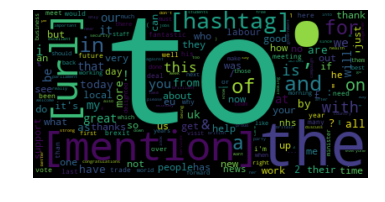

In [64]:
create_wordcloud(con_fql)

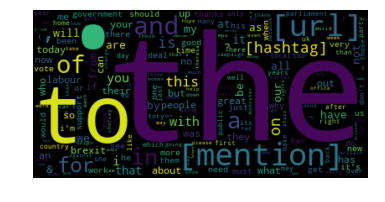

In [65]:
create_wordcloud(lab_fql)

Not that interesting as common words dominate. How could we remove these?

To normalise the frequencies, we can simply divide by the number of tokens, to gain relative frequencies.

In [66]:
def relative_freqs(fql):
    size = sum(fql.values())
    return {term: fql[term]/size for term in fql}

In [67]:
con_rel = relative_freqs(con_fql)
lab_rel = relative_freqs(lab_fql)

To do a "Key words" comparison between the sub-corpora, we can utilise [*Log Ratio*](http://cass.lancs.ac.uk/log-ratio-an-informal-introduction/), which is the binary log of the relative risk (ratio between relative frequencies). Other significance tests and effect size measures can be used: http://ucrel.lancs.ac.uk/llwizard.html

In [68]:
from math import log

#Calculates log ratio for terms in corpus1, compared to corpus2.
#we pass the corpus sizes for ease.
#If the term is not present in corpus2, we make the frequency 0.5.
def log_ratio(corpus1, corpus1_size, corpus2, corpus2_size):
    return {term: log((corpus1[term]/corpus1_size)/((corpus2[term] if corpus2[term] else 0.5)/corpus2_size),2) for term in corpus1}

Calculate the terms from Conservative MPs with the biggest log ratio compared to terms from Labour MPs:

[('welwyn', 9.054423130183011), ('ashford', 8.938326065260139), ('fm', 8.498904407354336), ('wgc', 8.1410108151791), ('bromsgrove', 7.604257407500565), ('counterpart', 6.978072244052896), ('orpington', 6.776438382883246), ('dit', 6.663963653624833), ('staffs', 6.663963653624833), ('farnham', 6.624435289438195), ('leonards', 6.541973129246222), ('mili', 6.498904407354337), ('exhibitors', 6.454510287995883), ('grt', 6.454510287995883), ("miliband's", 6.361400883604402), ("w'", 6.261865210053488), ('ebola', 6.209397790159351), ('putney', 6.182430742559083), ('ira', 6.154950006136976), ('southfields', 6.154950006136976)]


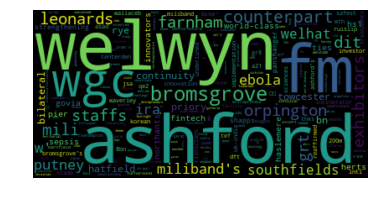

In [69]:
con_lr = log_ratio(con_fql, con_size, lab_fql, lab_size)
sorted_terms = sorted(con_lr.items(), key=lambda x: x[1], reverse=True)
print(sorted_terms[:20])
create_wordcloud(con_lr)

and the other way round:

[('chorley', 9.627638753357989), ('walthamstow', 9.25629614570347), ('thankyou', 8.061189550288159), ('….', 7.988433207852845), ('camden', 7.3528446340617215), ('↓', 6.920529143351041), ('→', 6.849270460181221), ('deportation', 6.7353142708841345), ('tottenham', 6.4762270495670045), ('hoylel', 6.3528446340617215), ("tories'", 6.300377214167585), ('tbh', 6.160199556119325), ('botched', 6.100078563681755), ('deported', 6.100078563681755), ('clp', 6.004921330641414), ('islamophobia', 6.004921330641414), ('holborn', 5.903041716622202), ('murdoch', 5.8674178068914795), ('ponty', 5.793417225447703), ('pancras', 5.754943077633067)]


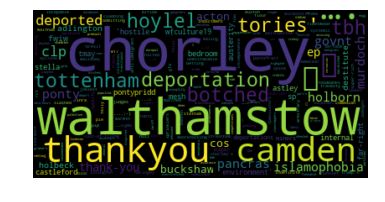

In [70]:
lab_lr = log_ratio(lab_fql, lab_size, con_fql, con_size)
sorted_terms = sorted(lab_lr.items(), key=lambda x: x[1], reverse=True)
print(sorted_terms[:20])
create_wordcloud(lab_lr)

Some interesting terms appear, but with a small number of authors, some terms will be prominent from one MP, boosting the frequency in the sub-corpus.

<a id="tfidf"></a>
## TF-IDF

As discussed in the lecture, TF-IDF is a commonly used normalisation method which considers the term frequency along with how many documents in the corpus the term appears in.

In [71]:
#doc is a Counter representing an fql from a document.
def tf(term, doc):
    return doc[term] / sum(doc.values()) #term freq / total terms (relative term freq)

def num_containing(term, corpus):
    return sum(1 for doc in corpus if term in doc) #counts docs in corpus containing term.

#1 added to numerator and denominator is for preventing division by zero. Equivalent of an extra document containing all terms once.
def idf(term, corpus):
    n_t = num_containing(term,corpus)
    return log((len(corpus)+1) / ((n_t) + 1))
    
def tfidf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

We can calculate the TF-IDF for every term for every MP in the corpus. By listing the terms with the highest TF-IDF, we can look at terms that are used by that MP frequently, but only used by that MP alone, or a small number of MPs.

In [72]:
corpus_fqls = [doc.tokens_fql for doc in corpus]
for doc in corpus:
    print(doc.meta['username'], doc.meta['party'])
    scores = {term: tfidf(term,doc.tokens_fql,corpus_fqls) for term in doc.tokens_fql}
    sorted_terms = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for term, score in sorted_terms[:5]:
        print("\tToken: {}, TF-IDF: {}".format(term, round(score, 5)))

OwenSmith_MP labour
	Token: mesh, TF-IDF: 0.00268
	Token: ponty, TF-IDF: 0.00258
	Token: pontypridd, TF-IDF: 0.0019
	Token: folic, TF-IDF: 0.00115
	Token: flour, TF-IDF: 0.00109
stellacreasy labour
	Token: walthamstow, TF-IDF: 0.01337
	Token: …., TF-IDF: 0.00554
	Token: …, TF-IDF: 0.00201
	Token: fwiw, TF-IDF: 0.00164
	Token: @, TF-IDF: 0.00126
YvetteCooperMP labour
	Token: shd, TF-IDF: 0.00222
	Token: tmay, TF-IDF: 0.00186
	Token: wd, TF-IDF: 0.00135
	Token: castleford, TF-IDF: 0.00119
	Token: pontefract, TF-IDF: 0.00085
CatSmithMP labour
	Token: fleetwood, TF-IDF: 0.00511
	Token: lancaster, TF-IDF: 0.00396
	Token: lancashire, TF-IDF: 0.00244
	Token: fracking, TF-IDF: 0.00124
	Token: ;-), TF-IDF: 0.00109
Ed_Miliband labour
	Token: →, TF-IDF: 0.00194
	Token: download, TF-IDF: 0.00165
	Token: ep, TF-IDF: 0.0014
	Token: podcast, TF-IDF: 0.00132
	Token: episode, TF-IDF: 0.00119
tom_watson labour
	Token: gambling, TF-IDF: 0.00138
	Token: sugar, TF-IDF: 0.00128
	Token: newsletter, TF-IDF: 0

<a id="ex"></a>
## Exercise
Use the MPs data you already have to conduct some further feature extraction and analysis. Please write code to answer the following questions:

1. Which MP in the dataset has the highest average word length?
2. What are the 5 **key part-of-speech tags** used by Labour MPs more than Conservative MPs?
3. **Advanced:** What hashtags does Jeremy Corbyn use frequetly, which aren't used widely by the rest of the Labour party MPs in the dataset (TF-IDF)?
4. **Advanced:** If you want to go further, devise your own research question, either using the MP data provided, [collecting more MPs](mp_accounts), or on different data.

You may need to pre-process and tokenise the text differently. I suggest re-using the code above, including adapting the Document class, adding/editing preprocessing, tokenisation, and feature extraction.

If you prefer, you can create a new notebook for the exercise work. The methods and imports above are provided in a Python file too: [features.py](features.py), to read this in use `%run features.py`

In [73]:
#Code for 1 here.
#Which MP in the dataset has the highest average word length?

'''
tokens_fql = Counter(lower_tokens)

tally = 0
for word in tokens_fql:
    tally += len(word) * tokens_fql[word]
    #print(tally)
final = tally/sum(tokens_fql.values())
        
print(tally)
tokens_fql
final
tokens_fql
sum(tokens_fql.values())
        
for document in corpus:
    for word in document.tokens_fql:
        print(word)
'''        

# If mps tweet single letter words alot and or use excessive singule punction such as , - ! then this will bring the average length down
TotalLengthOfEachWord = 0 
AverageWordLengthOfMP = []
# Go through each document
for document in corpus:
    TotalLengthOfEachWord = 0 
    # extract each word
    for word in document.tokens_fql:
        #Calc the cummulative total length of each word, needed to times the length of word by how many times it occured
        TotalLengthOfEachWord += (len(word) * doc.tokens_fql[word])
        #print('len of ',word, ' : ', len(word))
    #calc the average length by dividing by no of words
    averageLengthOfEachWord = TotalLengthOfEachWord/sum(document.tokens_fql.values())
    #Store result
    AverageWordLengthOfMP.append((document.meta['username'],averageLengthOfEachWord))

AverageWordLengthOfMP = sorted(AverageWordLengthOfMP, key=lambda x: x[1])
AverageWordLengthOfMP



[('DavidLammy', 2.3685723234519225),
 ('stellacreasy', 3.1243657163945016),
 ('jeremycorbyn', 3.632017479970867),
 ('grantshapps', 4.1512204104864905),
 ('Jeremy_Hunt', 4.570150905123398),
 ('Ed_Miliband', 4.61284602318332),
 ('ChukaUmunna', 4.63054587688734),
 ('tom_watson', 4.649570389953734),
 ('NadineDorries', 4.74661134720348),
 ('RupaHuq', 5.073765234124439),
 ('LindsayHoyle_MP', 5.127218168472864),
 ('CatSmithMP', 5.16505558240696),
 ('AmberRuddHR', 5.399977565900168),
 ('YvetteCooperMP', 5.595650140318054),
 ('OwenSmith_MP', 5.630009341988646),
 ('PhilipHammondUK', 6.02472745927921),
 ('Keir_Starmer', 6.25354484706905),
 ('BWallaceMP', 6.310039049788481),
 ('BorisJohnson', 6.5417135332364),
 ('hilarybennmp', 6.653816277798556),
 ('SamGyimah', 6.891589861751152),
 ('sajidjavid', 7.559196787148594),
 ('JustineGreening', 8.128161348842173),
 ('LiamFox', 8.302575355121839),
 ('theresa_may', 8.92161895360316),
 ('EmilyThornberry', 9.080980415715487),
 ('HackneyAbbott', 9.39178658310

In [ ]:
#Code for 2 here.
#What are the 5 key part-of-speech tags used by Labour MPs more than Conservative MPs?

def update_in_alist(alist, key, value):
    return [(k,v) if (k != key) else (key, value) for (k, v) in alist]

def update_in_alist_inplace(alist, key, value):
    alist[:] = update_in_alist(alist, key, value)

    
CountOfPartsOfSpeech =  []

# first do labour
for document in corpus:
    # extract each word
    if document.meta['party'] == 'labour':
        for word in document.tokens_fql:
            CountOfPartsOfSpeech.append((nltk.pos_tag([word])[0][1], document.tokens_fql[word] ))

my_set = {x[0] for x in CountOfPartsOfSpeech}
my_sums = [(i,sum(x[1] for x in CountOfPartsOfSpeech if x[0] == i)) for i in my_set]
my_sums = sorted(my_sums, key=lambda x: x[1], reverse=True)

print('Labour Top 5')
print(my_sums[:10])

# first do labour
for document in corpus:
    # extract each word
    if document.meta['party'] == 'conservative':
        for word in document.tokens_fql:
            CountOfPartsOfSpeech.append((nltk.pos_tag([word])[0][1], document.tokens_fql[word] ))

my_set = {x[0] for x in CountOfPartsOfSpeech}
my_sums = [(i,sum(x[1] for x in CountOfPartsOfSpeech if x[0] == i)) for i in my_set]
my_sums = sorted(my_sums, key=lambda x: x[1], reverse=True)

print('Conservative Top 5')
print(my_sums[:10])


In [ ]:
#Code for 3 here (advanced).

In [ ]:
#Code for 4 here (advanced).

### Answers:

1. 
2. 
3. 
4. Question: Answer